# Learning to optimize parametric Quadratically Constrained QP (pQCQP) using Neuromancer.

This is an interactive notebook based on the python script [Part_2_pQP.py](https://github.com/pnnl/neuromancer/blob/master/examples/parametric_programming/Part_2_pQP.py).

Problem formulation pQCQP:
$$
    \begin{align}
    &\text{minimize } &&   x^2 + y^2\\
    &\text{subject to} &&  -x - y + p1 \le 0\\
    &  &&     x^2 + y^2 \le p2^2\\
    \end{align}
$$


with parameters $p1, p2$ and decision variables $x, y$.

- https://colab.research.google.com/github/pnnl/neuromancer/blob/master/examples/parametric_programming/Part_2_pQP.ipynb#scrollTo=yD5kAnjy4CUL

### Import

In [ ]:
import cvxpy as cp
import numpy as np
import time
import torch
import torch.nn as nn
import neuromancer.slim as slim
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects

In [ ]:
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.constraint import variable
from neuromancer.dataset import DictDataset
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks
from neuromancer.system import Node

# Dataset

In [ ]:
data_seed = 408  # random seed used for simulated data
np.random.seed(data_seed)
torch.manual_seed(data_seed);

Randomly sample parameters from a uniform distribution: $1.0\le p1 \le11.0$;  $1.0\le p2 \le11.0$

In [ ]:
nsim = 3000  # number of datapoints: increase sample density for more robust results

# create dictionaries with sampled datapoints with uniform distribution
p_low, p_high = 1.0, 11.0
samples_train = {"p1": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high),
                 "p2": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high)}
samples_dev = {"p1": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high),
               "p2": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high)}
samples_test = {"p1": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high),
               "p2": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high)}

# create named dictionary datasets
train_data = DictDataset(samples_train, name='train')
dev_data = DictDataset(samples_dev, name='dev')
test_data = DictDataset(samples_test, name='test')

# create torch dataloaders for the Trainer
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, num_workers=0,
                                           collate_fn=train_data.collate_fn, shuffle=True)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=32, num_workers=0,
                                         collate_fn=dev_data.collate_fn, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, num_workers=0,
                                         collate_fn=test_data.collate_fn, shuffle=True)
# note: training quality will depend on the DataLoader parameters such as batch size and shuffle

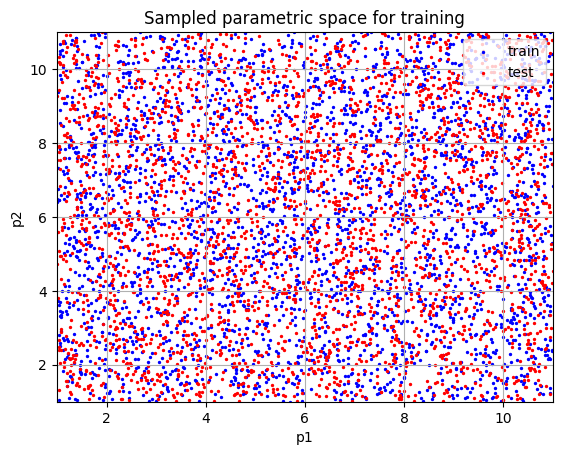

In [ ]:
# visualize taining and test samples for 2D parametric space
p1_train = samples_train['p1'].numpy()
p2_train = samples_train['p2'].numpy()
p1_dev = samples_dev['p1'].numpy()
p2_dev = samples_dev['p2'].numpy()
plt.figure()
plt.scatter(p1_train, p2_train, s=2., c='blue', marker='o')
plt.scatter(p1_dev, p2_dev, s=2., c='red', marker='o')
plt.title('Sampled parametric space for training')
plt.xlim(p_low, p_high)
plt.ylim(p_low, p_high)
plt.grid(True)
plt.xlabel('p1')
plt.ylabel('p2')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
plt.show(block=True)

# pQCQP Formulation in NeuroMANCER

## Primal Solution Map Architecture

In [ ]:
# define neural architecture for the solution map
func = blocks.MLP(insize=2, outsize=2,
                  bias=True,
                  linear_map=slim.maps['linear'],
                  nonlin=nn.ReLU,
                  hsizes=[80] * 4)

# wrap neural net into symbolic representation of the solution map via the Node class: sol_map(xi) -> x
sol_map = Node(func, ['p1', 'p2'], ['x'], name='map')

# trainable components of the problem solution
components = [sol_map]

## Objective and Constraints in NeuroMANCER

In [ ]:
"""
variable is a basic symbolic abstraction in Neuromancer
   x = variable("variable_name")                      (instantiates new variable)  
variable construction supports:
   algebraic expressions:     x**2 + x**3 + 5     (instantiates new variable)  
   slicing:                   x[:, i]             (instantiates new variable)  
   pytorch callables:         torch.sin(x)        (instantiates new variable)  
   constraints definition:    x <= 1.0            (instantiates Constraint object) 
   objective definition:      x.minimize()        (instantiates Objective object) 
to visualize computational graph of the variable use x.show() method          
"""

# variables
x = variable("x")[:, [0]]
y = variable("x")[:, [1]]
# sampled parameters
p1 = variable('p1')
p2 = variable('p2')

# objective function
f = x ** 2 + y ** 2
obj = f.minimize(weight=1.0, name='obj')
objectives = [obj]

# constraints
Q_con = 100.
g1 = -x - y + p1
con_1 = Q_con * (g1 <= 0)
con_1.name = 'c1'
# constraints for QCQP
g2 = x**2+y**2 - p2**2
con_2 = Q_con*(g2 <= 0)
con_2.name = 'c2'
constraints = [con_1, con_2]

In [ ]:
# create penalty method loss function
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss)

## Parametric Problem Solution in NeuroMANCER

In [ ]:
lr = 0.001      # step size for gradient descent
epochs = 400    # number of training epochs
warmup = 100    # number of epochs to wait before enacting early stopping policy
patience = 100  # number of epochs with no improvement in eval metric to allow before early stopping

In [ ]:
optimizer = torch.optim.AdamW(problem.parameters(), lr=lr)

# define trainer
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_loader,
    optimizer,
    epochs=epochs,
    patience=patience,
    warmup=warmup)

In [ ]:
# Train MLP solution map
best_model = trainer.train()
best_outputs = trainer.test(best_model)
# load best model dict
problem.load_state_dict(best_model)

epoch: 0  train_loss: 219.99407958984375
epoch: 1  train_loss: 131.47511291503906
epoch: 2  train_loss: 128.6796417236328
epoch: 3  train_loss: 128.02255249023438
epoch: 4  train_loss: 125.55276489257812
epoch: 5  train_loss: 128.80113220214844
epoch: 6  train_loss: 126.41915130615234
epoch: 7  train_loss: 122.95948028564453
epoch: 8  train_loss: 125.72586822509766
epoch: 9  train_loss: 128.58348083496094
epoch: 10  train_loss: 123.93965911865234
epoch: 11  train_loss: 124.76565551757812
epoch: 12  train_loss: 124.04854583740234
epoch: 13  train_loss: 123.82807159423828
epoch: 14  train_loss: 124.6999282836914
epoch: 15  train_loss: 122.33904266357422
epoch: 16  train_loss: 126.13388061523438
epoch: 17  train_loss: 125.62147521972656
epoch: 18  train_loss: 123.54672241210938
epoch: 19  train_loss: 124.04029083251953
epoch: 20  train_loss: 128.1658935546875
epoch: 21  train_loss: 128.6768341064453
epoch: 22  train_loss: 121.53119659423828
epoch: 23  train_loss: 124.13874816894531
epoch:

<All keys matched successfully>

## Get a QCQP solution from CVXPY as a benchmark

[CVXPY](https://www.cvxpy.org/) is an open-source tool for constrained optimization that has influenced the development of NeuroMANCER.

In [ ]:
# Define the CVXPY problems.
def QCQP_param(p1, p2):
    x = cp.Variable(1)
    y = cp.Variable(1)
    prob = cp.Problem(cp.Minimize(x ** 2 + y ** 2),
                  [-x - y + p1 <= 0,
                   x ** 2 + y ** 2 - p2 ** 2 <= 0])
    return prob, x, y

## Compare: NeuroMANCER vs. CVXPY

parameter p=(2.0, 2.0)
primal solution CVXPY x=[1.], y=[1.]
primal solution Neuromancer x1=1.061104416847229, x2=1.0426446199417114
parameter p=(3.0, 3.0)
primal solution CVXPY x=[1.5], y=[1.5]
primal solution Neuromancer x1=1.5613796710968018, x2=1.5433149337768555
parameter p=(4.0, 4.0)
primal solution CVXPY x=[2.], y=[2.]
primal solution Neuromancer x1=2.0616018772125244, x2=2.0440151691436768
parameter p=(5.0, 5.0)
primal solution CVXPY x=[2.5], y=[2.5]
primal solution Neuromancer x1=2.5625052452087402, x2=2.544935703277588
parameter p=(6.0, 6.0)
primal solution CVXPY x=[3.], y=[3.]
primal solution Neuromancer x1=3.0589406490325928, x2=3.0412938594818115
parameter p=(7.0, 7.0)
primal solution CVXPY x=[3.5], y=[3.5]
primal solution Neuromancer x1=3.5540549755096436, x2=3.535916805267334
parameter p=(8.0, 8.0)
primal solution CVXPY x=[4.], y=[4.]
primal solution Neuromancer x1=4.049169063568115, x2=4.030539512634277
parameter p=(9.0, 9.0)
primal solution CVXPY x=[4.5], y=[4.5]
primal

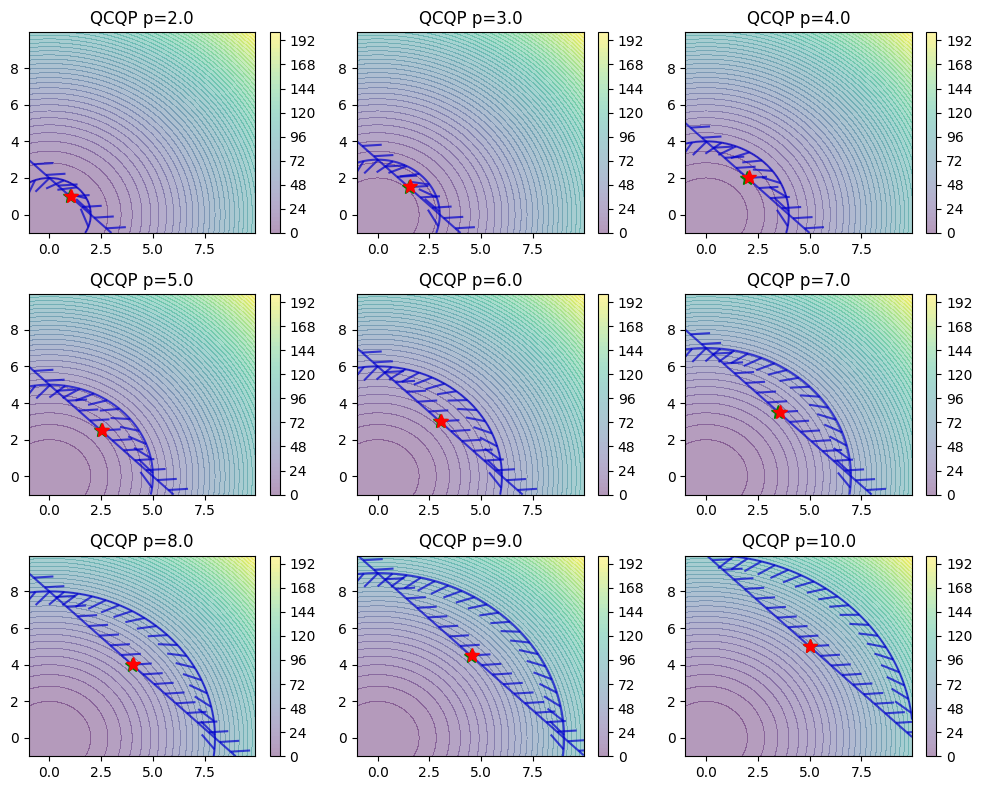

In [ ]:
"""
Plots
"""
# test problem parameters
params = [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
x1 = np.arange(-1.0, 10.0, 0.05)
y1 = np.arange(-1.0, 10.0, 0.05)
xx, yy = np.meshgrid(x1, y1)
fig, ax = plt.subplots(3,3, figsize=(10, 8))
row_id = 0
column_id = 0
for i, p in enumerate(params):
    if i % 3 == 0 and i != 0:
        row_id += 1
        column_id = 0

    # eval and plot objective and constraints
    J = xx ** 2 + yy ** 2
    cp_plot = ax[row_id, column_id].contourf(xx, yy, J, 50, alpha=0.4)
    ax[row_id, column_id].set_title(f'QCQP p={p}')
    # constraints for QCQP
    c1 = xx + yy - p
    c2 = - xx**2 - yy**2 + p**2
    cg1 = ax[row_id, column_id].contour(xx, yy, c1, [0], colors='mediumblue', alpha=0.7)
    cg2 = ax[row_id, column_id].contour(xx, yy, c2, [0], colors='mediumblue', alpha=0.7)
    cg1.set(path_effects=[patheffects.withTickedStroke()], alpha=0.7)
    cg2.set(path_effects=[patheffects.withTickedStroke()], alpha=0.7)
    fig.colorbar(cp_plot, ax=ax[row_id,column_id])

    # Solve CVXPY problem
    prob, x, y = QCQP_param(p, p)
    prob.solve()

    # Solve via neuromancer
    datapoint = {'p1': torch.tensor([[p]]), 'p2': torch.tensor([[p]]),
                 'name': 'test'}
    model_out = problem(datapoint)
    x_nm = model_out['test_' + "x"][0, 0].detach().numpy()
    y_nm = model_out['test_' + "x"][0, 1].detach().numpy()

    print(f'parameter p={p, p}')
    print(f'primal solution CVXPY x={x.value}, y={y.value}')
    print(f'primal solution Neuromancer x1={x_nm}, x2={y_nm}')
    # print(f' f: {model_out["test_" + f.key]}')
    # print(f' g1: {model_out["test_" + g1.key]}')
    # print(f' g2: {model_out["test_" + g2.key]}')

    # Plot optimal solutions
    ax[row_id, column_id].plot(x.value, y.value, 'g*', markersize=10)
    ax[row_id, column_id].plot(x_nm, y_nm, 'r*', markersize=10)
    column_id += 1
plt.tight_layout()
plt.show()
plt.show(block=True)
plt.interactive(False)

# Green Star = CVXPY solution
# Red Star = Neuromancer solution

In [ ]:
"""
Benchmark Solution
"""

def eval_constraints(x, y, p1, p2):
    """
    evaluate mean constraints violations
    """
    con_1_viol = np.maximum(0, -x - y + p1)
    con_2_viol = np.maximum(0, x**2 + y**2 - p2**2)
    con_viol = con_1_viol + con_2_viol
    con_viol_mean = np.mean(con_viol)
    return con_viol_mean

def eval_objective(x, y, a1=1, a2=1):
    obj_value_mean = np.mean(a1 * x**2 + a2 * y**2)
    return obj_value_mean

# Solve via neuromancer
t = time.time()
samples_test['name'] = 'test'
model_out = problem(samples_test)
nm_time = time.time() - t
x_nm = model_out['test_' + "x"][:, [0]].detach().numpy()
y_nm = model_out['test_' + "x"][:, [1]].detach().numpy()

# Solve via solver
t = time.time()
x_solver, y_solver = [], []
for i in range(0, nsim):
    p1 = samples_test['p1'][i].detach().numpy()
    p2 = samples_test['p2'][i].detach().numpy()
    prob, x, y = QCQP_param(p1, p2)
    prob.solve()
    x_solver.append(x.value)
    y_solver.append(y.value)
solver_time = time.time() - t
x_solver = np.asarray(x_solver, dtype=object)
y_solver = np.asarray(y_solver, dtype=object)

In [ ]:
x_solver = x_solver.astype(np.float32)
y_solver = y_solver.astype(np.float32)

In [ ]:
# Evaluate neuromancer solution
print(f'Solution for {nsim} problems via Neuromancer obtained in {nm_time:.4f} seconds')
x_nm = x_nm[~np.isnan(x_solver)]
y_nm = y_nm[~np.isnan(y_solver)]
nm_con_viol_mean = eval_constraints(x_nm, y_nm, p1, p2)
print(f'Neuromancer mean constraints violation {nm_con_viol_mean:.4f}')
nm_obj_mean = eval_objective(x_nm, y_nm)
print(f'Neuromancer mean objective value {nm_obj_mean:.4f}')

# Evaluate solver solution
print(f'Solution for {nsim} problems via solver obtained in {solver_time:.4f} seconds')
x_solver = x_solver[~np.isnan(x_solver)]
y_solver = y_solver[~np.isnan(y_solver)]
solver_con_viol_mean = eval_constraints(x_solver, y_solver, p1, p2)
print(f'Solver mean constraints violation {solver_con_viol_mean:.4f}')
solver_obj_mean = eval_objective(x_solver, y_solver)
print(f'Solver mean objective value {solver_obj_mean:.4f}')

# neuromancer solver comparison
speedup_factor = solver_time/nm_time
print(f'Solution speedup factor {speedup_factor:.4f}')

# Difference in primal optimizers
dx = (x_solver - x_nm)[:,0]
dy = (y_solver - y_nm)[:,0]
err_x = np.mean(dx**2)
err_y = np.mean(dy**2)
err_primal = err_x + err_y
print('MSE primal optimizers:', err_primal)

# Difference in objective
err_obj = np.abs(solver_obj_mean - nm_obj_mean) / solver_obj_mean * 100
print(f'mean objective value discrepancy: {err_obj:.2f} %')

# stats to log
stats = {"nsim": nsim,
         "nm_time": nm_time,
         "nm_con_viol_mean": nm_con_viol_mean,
         "nm_obj_mean": nm_obj_mean,
         "solver_time": solver_time,
         "solver_con_viol_mean": solver_con_viol_mean,
         "solver_obj_mean": solver_obj_mean,
         "speedup_factor": speedup_factor,
         "err_primal": err_primal,
         "err_obj": err_obj}

Solution for 3000 problems via Neuromancer obtained in 0.0041 seconds
Neuromancer mean constraints violation 0.0553
Neuromancer mean objective value 17.9081
Solution for 3000 problems via solver obtained in 25.9290 seconds
Solver mean constraints violation 0.0812
Solver mean objective value 17.4534
Solution speedup factor 6344.6875
MSE primal optimizers: 7.3954535
mean objective value discrepancy: 2.61 %
